# 2. Descriptive Data Analysis - Data Normalization

## 2.1 Import the Libs

In [78]:
import pandas as pd
import requests
import lxml
from bs4 import BeautifulSoup
import time
import pyodbc
import numpy as np
from urllib.error import URLError, HTTPError
from urllib.request import Request, urlopen
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import matplotlib.pyplot as plt

## 2.2 Reading data From Database

In [79]:
# Function Select
def SQLSelect(query):
    conn = pyodbc.connect('Trusted_Connection=yes',
                      driver = '{ODBC Driver 17 for SQL Server}',
                      server = 'localhost',
                      database = 'MLS_Project')
    out = pd.read_sql_query(query,conn)
    return out

query_all_rank = '''
    Select 
    * 
    from TableRankBase
'''
query_all_details = '''
    Select 
    * 
    from TableDetailsBase
'''
query_max_rank = '''
    SELECT
        maior = max(Proposicao)
    from TableDetailsBase
'''
query_max_details = '''
    SELECT
        maior = max(Proposicao)
    from TableDetailsBase
'''


In [80]:
df_rank = SQLSelect(query_all_rank)
df_rank_details = SQLSelect(query_all_details)

In [81]:
df_rank.head()

,Generalkey,RK,TEAM_NAME,MP,W,D,L,GF,GA,GD,PTS,PTS_MP,XG,XGA,XGD,XGD_90,NOTES,CONFERENCE,SEASON
0,1,1,Philadelphia,23,14,5,4,44,20,24,47,2.04,35.0,23.5,11.4,0.57,? First Round,EastConf,2020
1,2,2,Toronto FC,23,13,5,5,33,26,7,44,1.91,31.1,22.5,8.6,0.43,? First Round,EastConf,2020
2,3,3,Columbus Crew,23,12,5,6,36,21,15,41,1.78,28.6,28.1,0.5,0.03,? First Round,EastConf,2020
3,4,4,Orlando City,23,11,8,4,40,25,15,41,1.78,27.5,24.3,3.2,0.16,? First Round,EastConf,2020
4,5,5,NYCFC,23,12,3,8,37,25,12,39,1.70,33.3,26.7,6.7,0.33,? First Round,EastConf,2020


In [82]:
df_rank_details.head()

,Generalkey,TEAM_NAME,GAME_Date,GAME_Time,Comp,SEASON_Round,WEEK_DAY,TEAM_Venue,GAME_Result,GF,...,Opponent,XG,XGA,POSS,ATTENDANCE,Captain,Formation,Referee,Notes,SEASON
0,1,Sporting-KC,2020-02-29,19:30:00,MLS,Regular Season,Sat,Away,W,3,...,Vancouver,0.5,2.2,52,22120.0,Matt Besler,4-3-3,Ted Unkel,,2020
1,2,Sporting-KC,2020-03-07,19:30:00,MLS,Regular Season,Sat,Home,W,4,...,Houston Dynamo,2.6,0.7,56,21188.0,Matt Besler,4-3-3,Allen Chapman,,2020
2,3,Sporting-KC,2020-08-21,18:30:00,MLS,Regular Season,Fri,Away,W,2,...,Minnesota Utd,0.9,0.9,42,0.0,Alan Pulido,4-3-3,Ramy Touchan,,2020
3,4,Sporting-KC,2020-08-25,19:30:00,MLS,Regular Season,Tue,Home,L,2,...,Houston Dynamo,2.2,2.6,49,0.0,Alan Pulido,4-1-4-1,Joe Dickerson,,2020
4,5,Sporting-KC,2020-08-29,19:00:00,MLS,Regular Season,Sat,Away,D,1,...,Colorado Rapids,0.6,1.2,38,0.0,Alan Pulido,4-1-4-1,Armando Villarreal,,2020


In [83]:
df_rank_details.iloc[[4071,4105],]

,Generalkey,TEAM_NAME,GAME_Date,GAME_Time,Comp,SEASON_Round,WEEK_DAY,TEAM_Venue,GAME_Result,GF,...,Opponent,XG,XGA,POSS,ATTENDANCE,Captain,Formation,Referee,Notes,SEASON
4071,4072,CF-Montreal,2022-07-30,19:30:00,MLS,Regular Season,Sat,Home,D,0,...,NYCFC,0.8,0.1,59,19619.0,Samuel Piette,3-1-4-2,Ramy Touchan,,2022
4105,4106,New-York-City-FC,2022-07-30,19:30:00,MLS,Regular Season,Sat,Away,D,0,...,CF Montréal,0.1,0.8,41,19619.0,Sean Johnson,4-2-3-1,Ramy Touchan,,2022


In [84]:
pd.DataFrame(df_rank['TEAM_NAME'].unique().tolist())
pd.DataFrame(df_rank_details['TEAM_NAME'].unique().tolist())
pd.DataFrame(df_rank_details['Opponent'].unique().tolist())


,0
0,Vancouver
1,Houston Dynamo
2,Minnesota Utd
3,Colorado Rapids
4,FC Dallas
5,Orlando City
6,Chicago Fire
7,Nashville
8,FC Cincinnati
9,Real Salt Lake


## 2.3 Standarizing the Team Names

In [85]:
# Mapping for Team_Names (attention to Montreal Impact and CF Montreal, changed name in 2021)
TEAM_NAME_dict = {'Atlanta Utd':'Atlanta-United',
                  'Austin':'Austin-FC',
                  'CF Montréal':'CF-Montreal',
                  'Charlotte':'Charlotte-FC',
                  'Chicago Fire':'Chicago-Fire',
                  'Colorado Rapids':'Colorado-Rapids',
                  'Columbus Crew':'Columbus-Crew',
                  'D.C. United':'DC-United',
                  'FC Cincinnati':'FC-Cincinnati',
                  'FC Dallas':'FC-Dallas',
                  'Houston Dynamo':'Houston-Dynamo',
                  'Inter Miami':'Inter-Miami',
                  'LA Galaxy':'LA-Galaxy',
                  'Los Angeles FC':'Los-Angeles-FC',
                  'Minnesota Utd':'Minnesota-United',
                  'Montreal Impact':'CF-Montreal',
                  'Nashville':'Nashville-SC',
                  'New England':'New-England-Revolution',
                  'NYCFC':'New-York-City-FC',
                  'NY Red Bulls':'New-York-Red-Bulls',
                  'Orlando City':'Orlando-City',
                  'Philadelphia':'Philadelphia-Union',
                  'Portland Timbers':'Portland-Timbers',
                  'Real Salt Lake':'Real-Salt-Lake',
                  'San Jose':'San-Jose-Earthquakes',
                  'Seattle':'Seattle-Sounders-FC',
                  'Sporting KC':'Sporting-KC',
                  'St. Louis':'St-Louis-City',
                  'Toronto FC':'Toronto-FC',
                  'Vancouver':'Vancouver-Whitecaps-FC'}

df_rank['TEAM_NAME'] = df_rank['TEAM_NAME'].map(TEAM_NAME_dict)
df_rank_details['Opponent'] = df_rank_details['Opponent'].map(TEAM_NAME_dict)

In [86]:
df_rank['TEAM_NAME'].unique().tolist()

['Philadelphia-Union',
 'Toronto-FC',
 'Columbus-Crew',
 'Orlando-City',
 'New-York-City-FC',
 'New-York-Red-Bulls',
 'Nashville-SC',
 'New-England-Revolution',
 'CF-Montreal',
 'Inter-Miami',
 'Chicago-Fire',
 'Atlanta-United',
 'DC-United',
 'FC-Cincinnati',
 'Sporting-KC',
 'Seattle-Sounders-FC',
 'Portland-Timbers',
 'Minnesota-United',
 'FC-Dallas',
 'Los-Angeles-FC',
 'San-Jose-Earthquakes',
 'Colorado-Rapids',
 'Vancouver-Whitecaps-FC',
 'LA-Galaxy',
 'Real-Salt-Lake',
 'Houston-Dynamo',
 'Austin-FC',
 'Charlotte-FC',
 'St-Louis-City']

In [87]:
df_rank_details['TEAM_NAME'].unique().tolist()

['Sporting-KC',
 'Seattle-Sounders-FC',
 'Portland-Timbers',
 'Minnesota-United',
 'FC-Dallas',
 'Los-Angeles-FC',
 'San-Jose-Earthquakes',
 'Colorado-Rapids',
 'Vancouver-Whitecaps-FC',
 'LA-Galaxy',
 'Real-Salt-Lake',
 'Houston-Dynamo',
 'Philadelphia-Union',
 'Toronto-FC',
 'Columbus-Crew',
 'Orlando-City',
 'New-York-City-FC',
 'New-York-Red-Bulls',
 'Nashville-SC',
 'New-England-Revolution',
 'Montreal-Impact',
 'Inter-Miami',
 'Chicago-Fire',
 'Atlanta-United',
 'DC-United',
 'FC-Cincinnati',
 'Austin-FC',
 'CF-Montreal',
 'Charlotte-FC',
 'St-Louis-City']

In [88]:
df_rank_details['Opponent'].unique().tolist()

['Vancouver-Whitecaps-FC',
 'Houston-Dynamo',
 'Minnesota-United',
 'Colorado-Rapids',
 'FC-Dallas',
 'Orlando-City',
 'Chicago-Fire',
 'Nashville-SC',
 'FC-Cincinnati',
 'Real-Salt-Lake',
 'Columbus-Crew',
 'Portland-Timbers',
 'Los-Angeles-FC',
 'San-Jose-Earthquakes',
 'LA-Galaxy',
 'Seattle-Sounders-FC',
 'Sporting-KC',
 'Philadelphia-Union',
 'CF-Montreal',
 'Atlanta-United',
 'Inter-Miami',
 'Toronto-FC',
 'DC-United',
 'New-York-Red-Bulls',
 'New-England-Revolution',
 'New-York-City-FC',
 'Austin-FC',
 'Charlotte-FC',
 'St-Louis-City']

## 2.4 General Description Data

In [89]:
df_rank.describe()

,Generalkey,RK,MP,W,D,L,GF,GA,GD,PTS,PTS_MP,XG,XGA,XGD,XGD_90,SEASON
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.00000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,110.000000,6.694064,28.885845,10.885845,7.114155,10.885845,42.09589,42.095890,0.000000,39.771689,1.374612,28.095890,28.096347,0.000913,-0.000868,2019.333333
std,63.364028,3.696330,9.804545,4.896238,3.453589,5.114356,17.09485,17.397272,13.653981,16.348075,0.359059,23.751416,23.647844,9.062717,0.340669,2.567141
min,1.000000,1.000000,5.000000,0.000000,0.000000,0.000000,2.00000,2.000000,-44.000000,3.000000,0.500000,0.000000,0.000000,-28.600000,-1.300000,2015.000000
25%,55.500000,4.000000,28.500000,8.000000,5.000000,8.000000,36.00000,35.500000,-8.000000,32.000000,1.150000,0.000000,0.000000,-2.950000,-0.150000,2017.000000
50%,110.000000,7.000000,34.000000,12.000000,7.000000,11.000000,46.00000,45.000000,0.000000,43.000000,1.390000,31.200000,30.500000,0.000000,0.000000,2020.000000
75%,164.500000,10.000000,34.000000,14.000000,9.000000,14.000000,53.00000,54.000000,8.000000,51.000000,1.575000,50.150000,49.400000,2.600000,0.110000,2022.000000
max,219.000000,15.000000,34.000000,22.000000,18.000000,22.000000,85.00000,75.000000,48.000000,73.000000,2.500000,80.000000,65.300000,40.700000,1.200000,2023.000000


In [90]:
df_rank_details.describe()

,Generalkey,GF,GA,XG,XGA,POSS,ATTENDANCE,SEASON
count,7076.000000,7076.000000,7076.000000,7076.000000,7076.000000,7076.000000,7076.000000,7076.000000
mean,3538.500000,1.288864,1.288864,0.869573,0.869573,39.398672,16600.961843,2019.298474
std,2042.809585,1.248805,1.248805,0.950797,0.950797,21.874419,11719.087689,2.622911
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000
25%,1769.750000,0.000000,0.000000,0.000000,0.000000,35.000000,11007.000000,2017.000000
50%,3538.500000,1.000000,1.000000,0.700000,0.700000,47.000000,18000.000000,2019.000000
75%,5307.250000,2.000000,2.000000,1.500000,1.500000,54.000000,21517.000000,2022.000000
max,7076.000000,7.000000,7.000000,5.700000,5.700000,83.000000,74479.000000,2023.000000


In [91]:
df_rank_TeamYearGames = df_rank.groupby(['TEAM_NAME','SEASON'])['MP'].sum().unstack(level = 1)
df_rank_TeamYearGames.fillna(0)

SEASON,2015,2016,2017,2018,2019,2020,2021,2022,2023
TEAM_NAME,,,,,,,,,
Atlanta-United,0.0,0.0,34.0,34.0,34.0,23.0,34.0,34.0,6.0
Austin-FC,0.0,0.0,0.0,0.0,0.0,0.0,34.0,34.0,5.0
CF-Montreal,34.0,34.0,34.0,34.0,34.0,23.0,34.0,34.0,5.0
Charlotte-FC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,6.0
Chicago-Fire,34.0,34.0,34.0,34.0,34.0,23.0,34.0,34.0,5.0
Colorado-Rapids,34.0,34.0,34.0,34.0,34.0,18.0,34.0,34.0,6.0
Columbus-Crew,34.0,34.0,34.0,34.0,34.0,23.0,34.0,34.0,6.0
DC-United,34.0,34.0,34.0,34.0,34.0,23.0,34.0,34.0,6.0
FC-Cincinnati,0.0,0.0,0.0,0.0,34.0,23.0,34.0,34.0,6.0


In [92]:
df_rank_TeamYearGames = df_rank_details.groupby(['TEAM_Venue','GAME_Result'])['WEEK_DAY'].count().unstack(level = 1)
df_rank_TeamYearGames

GAME_Result,,D,L,W
TEAM_Venue,,,,
Away,411,769,1604,754
Home,411,769,754,1604


In [93]:
df_rank_details_TeamYearGames = df_rank_details.groupby(['TEAM_NAME','SEASON'])['Comp'].count().unstack(level = 1)
df_rank_details_TeamYearGames.fillna(0)

SEASON,2015,2016,2017,2018,2019,2020,2021,2022,2023
TEAM_NAME,,,,,,,,,
Atlanta-United,0.0,0.0,34.0,34.0,34.0,20.0,34.0,34.0,34.0
Austin-FC,0.0,0.0,0.0,0.0,0.0,0.0,34.0,34.0,34.0
CF-Montreal,0.0,0.0,0.0,0.0,0.0,0.0,34.0,34.0,34.0
Charlotte-FC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,34.0
Chicago-Fire,34.0,34.0,34.0,34.0,34.0,20.0,34.0,34.0,34.0
Colorado-Rapids,34.0,34.0,34.0,34.0,34.0,15.0,34.0,34.0,34.0
Columbus-Crew,34.0,34.0,34.0,34.0,34.0,20.0,34.0,34.0,34.0
DC-United,34.0,34.0,34.0,34.0,34.0,20.0,34.0,34.0,34.0
FC-Cincinnati,0.0,0.0,0.0,0.0,34.0,20.0,34.0,34.0,34.0


In [94]:
df_rank_TeamYearRank = df_rank.groupby(['TEAM_NAME','SEASON'])['RK'].sum().unstack(level = 1)
df_rank_TeamYearRank.fillna(0)

SEASON,2015,2016,2017,2018,2019,2020,2021,2022,2023
TEAM_NAME,,,,,,,,,
Atlanta-United,0.0,0.0,4.0,2.0,2.0,12.0,5.0,11.0,2.0
Austin-FC,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0,7.0
CF-Montreal,3.0,5.0,9.0,7.0,9.0,9.0,10.0,2.0,15.0
Charlotte-FC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,14.0
Chicago-Fire,10.0,10.0,3.0,10.0,8.0,11.0,12.0,12.0,11.0
Colorado-Rapids,10.0,2.0,10.0,11.0,9.0,8.0,1.0,10.0,14.0
Columbus-Crew,2.0,9.0,5.0,5.0,10.0,3.0,9.0,8.0,4.0
DC-United,4.0,4.0,11.0,4.0,5.0,13.0,8.0,14.0,13.0
FC-Cincinnati,0.0,0.0,0.0,0.0,12.0,14.0,14.0,5.0,1.0


In [95]:
df_rank_TeamYears = pd.DataFrame(df_rank.groupby('SEASON')['TEAM_NAME'].count())
df_rank_TeamYears

,TEAM_NAME
SEASON,
2015,20
2016,20
2017,22
2018,23
2019,24
2020,26
2021,27
2022,28
2023,29


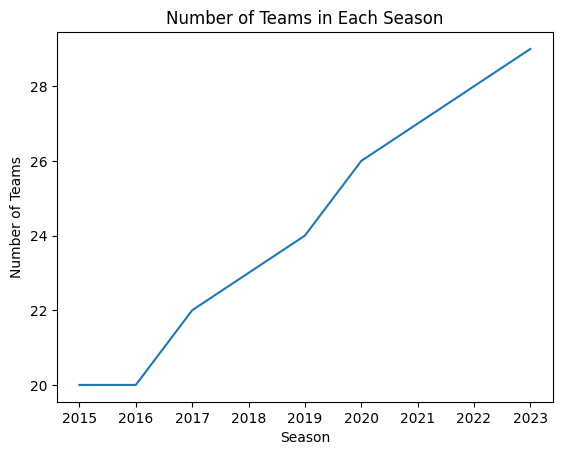

In [96]:
df_rank_TeamYears.plot()
plt.title("Number of Teams in Each Season")
plt.ylabel("Number of Teams")
plt.xlabel("Season")
plt.legend().remove()
plt.show()

In [97]:
df_rank_TeamYears_MP = df_rank_details_TeamYearGames.copy()
df_rank_TeamYears_MP = df_rank_TeamYears_MP.fillna(0)
df_rank_TeamYears_MP.transpose()

TEAM_NAME,Atlanta-United,Austin-FC,CF-Montreal,Charlotte-FC,Chicago-Fire,Colorado-Rapids,Columbus-Crew,DC-United,FC-Cincinnati,FC-Dallas,...,Orlando-City,Philadelphia-Union,Portland-Timbers,Real-Salt-Lake,San-Jose-Earthquakes,Seattle-Sounders-FC,Sporting-KC,St-Louis-City,Toronto-FC,Vancouver-Whitecaps-FC
SEASON,,,,,,,,,,,,,,,,,,,,,
2015,0.0,0.0,0.0,0.0,34.0,34.0,34.0,34.0,0.0,34.0,...,34.0,34.0,34.0,34.0,34.0,34.0,34.0,0.0,34.0,34.0
2016,0.0,0.0,0.0,0.0,34.0,34.0,34.0,34.0,0.0,34.0,...,34.0,34.0,34.0,34.0,34.0,34.0,34.0,0.0,34.0,34.0
2017,34.0,0.0,0.0,0.0,34.0,34.0,34.0,34.0,0.0,34.0,...,34.0,34.0,34.0,34.0,34.0,34.0,34.0,0.0,34.0,34.0
2018,34.0,0.0,0.0,0.0,34.0,34.0,34.0,34.0,0.0,34.0,...,34.0,34.0,34.0,34.0,34.0,34.0,34.0,0.0,34.0,34.0
2019,34.0,0.0,0.0,0.0,34.0,34.0,34.0,34.0,34.0,34.0,...,34.0,34.0,34.0,34.0,34.0,34.0,34.0,0.0,34.0,34.0
2020,20.0,0.0,0.0,0.0,20.0,15.0,20.0,20.0,20.0,22.0,...,20.0,20.0,20.0,19.0,20.0,19.0,19.0,0.0,20.0,20.0
2021,34.0,34.0,34.0,0.0,34.0,34.0,34.0,34.0,34.0,34.0,...,34.0,34.0,34.0,34.0,34.0,34.0,34.0,0.0,34.0,34.0
2022,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,...,34.0,34.0,34.0,34.0,34.0,34.0,34.0,0.0,34.0,34.0
2023,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,...,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0


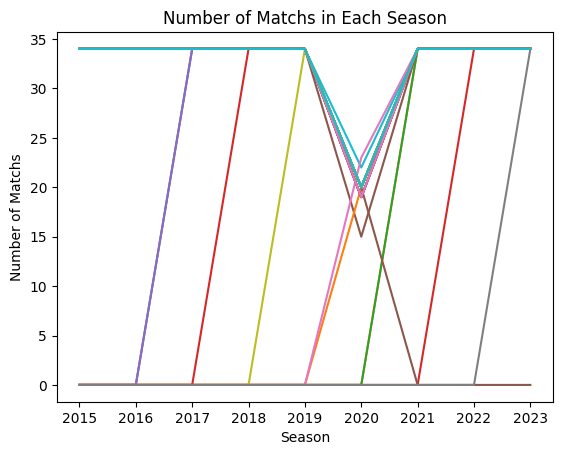

In [98]:
df_rank_TeamYears_MP.transpose().plot()
plt.title("Number of Matchs in Each Season")
plt.ylabel("Number of Matchs")
plt.xlabel("Season")
plt.legend().remove()
plt.show()

# 2.5 Data Cleaning, Feature Creating and Removing duplicates


At this step will be created a UNIQUE list of games with the variable Result = ["H", "A","D"]

### 2.5.1 Looking for Standarize the names on Rank Details

In [101]:
df_rank_details['TEAM_NAME'].unique().tolist()

['Sporting-KC',
 'Seattle-Sounders-FC',
 'Portland-Timbers',
 'Minnesota-United',
 'FC-Dallas',
 'Los-Angeles-FC',
 'San-Jose-Earthquakes',
 'Colorado-Rapids',
 'Vancouver-Whitecaps-FC',
 'LA-Galaxy',
 'Real-Salt-Lake',
 'Houston-Dynamo',
 'Philadelphia-Union',
 'Toronto-FC',
 'Columbus-Crew',
 'Orlando-City',
 'New-York-City-FC',
 'New-York-Red-Bulls',
 'Nashville-SC',
 'New-England-Revolution',
 'CF-Montreal',
 'Inter-Miami',
 'Chicago-Fire',
 'Atlanta-United',
 'DC-United',
 'FC-Cincinnati',
 'Austin-FC',
 'Charlotte-FC',
 'St-Louis-City']

In [100]:
TEAM_NAME_dict2 = { 
                    'Atlanta-United': 'Atlanta-United',
                    'Austin-FC': 'Austin-FC', 
                    'CF-Montreal': 'CF-Montreal', 
                    'Charlotte-FC': 'Charlotte-FC',
                    'Chicago-Fire': 'Chicago-Fire', 
                    'Colorado-Rapids': 'Colorado-Rapids', 
                    'Columbus-Crew': 'Columbus-Crew', 
                    'DC-United': 'DC-United', 
                    'FC-Cincinnati': 'FC-Cincinnati', 
                    'FC-Dallas': 'FC-Dallas', 
                    'Houston-Dynamo': 'Houston-Dynamo', 
                    'Inter-Miami': 'Inter-Miami', 
                    'LA-Galaxy': 'LA-Galaxy', 
                    'Los-Angeles-FC': 'Los-Angeles-FC', 
                    'Minnesota-United': 'Minnesota-United', 
                    'Montreal-Impact': 'CF-Montreal', 
                    'Nashville-SC': 'Nashville-SC', 
                    'New-England-Revolution': 'New-England-Revolution', 
                    'New-York-City-FC': 'New-York-City-FC', 
                    'New-York-Red-Bulls': 'New-York-Red-Bulls', 
                    'Orlando-City': 'Orlando-City', 
                    'Philadelphia-Union': 'Philadelphia-Union', 
                    'Portland-Timbers': 'Portland-Timbers', 
                    'Real-Salt-Lake': 'Real-Salt-Lake', 
                    'San-Jose-Earthquakes': 'San-Jose-Earthquakes', 
                    'Seattle-Sounders-FC': 'Seattle-Sounders-FC', 
                    'Sporting-KC': 'Sporting-KC',
                    'St-Louis-City':'St-Louis-City',
                    'Toronto-FC': 'Toronto-FC', 
                    'Vancouver-Whitecaps-FC': 'Vancouver-Whitecaps-FC'
}
df_rank_details['TEAM_NAME'] = df_rank_details['TEAM_NAME'].map(TEAM_NAME_dict2)

In [102]:
#Duplicate the base to remain rastreability
df_rank_details_V2 = df_rank_details.copy(deep=True)

In [103]:
print(df_rank_details.info())
print(df_rank_details_V2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7076 entries, 0 to 7075
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Generalkey    7076 non-null   int64  
 1   TEAM_NAME     7076 non-null   object 
 2   GAME_Date     7076 non-null   object 
 3   GAME_Time     7076 non-null   object 
 4   Comp          7076 non-null   object 
 5   SEASON_Round  7076 non-null   object 
 6   WEEK_DAY      7076 non-null   object 
 7   TEAM_Venue    7076 non-null   object 
 8   GAME_Result   7076 non-null   object 
 9   GF            7076 non-null   int64  
 10  GA            7076 non-null   int64  
 11  Opponent      7076 non-null   object 
 12  XG            7076 non-null   float64
 13  XGA           7076 non-null   float64
 14  POSS          7076 non-null   int64  
 15  ATTENDANCE    7076 non-null   float64
 16  Captain       7076 non-null   object 
 17  Formation     7076 non-null   object 
 18  Referee       7076 non-null 

In [104]:
#Removing unecessary columns
columns_to_remove = ['Generalkey','Comp','SEASON_Round','ATTENDANCE','Captain','Formation','Referee','Notes']
df_rank_details_V2 = df_rank_details_V2.drop(columns=columns_to_remove)
df_rank_details_V2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7076 entries, 0 to 7075
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TEAM_NAME    7076 non-null   object 
 1   GAME_Date    7076 non-null   object 
 2   GAME_Time    7076 non-null   object 
 3   WEEK_DAY     7076 non-null   object 
 4   TEAM_Venue   7076 non-null   object 
 5   GAME_Result  7076 non-null   object 
 6   GF           7076 non-null   int64  
 7   GA           7076 non-null   int64  
 8   Opponent     7076 non-null   object 
 9   XG           7076 non-null   float64
 10  XGA          7076 non-null   float64
 11  POSS         7076 non-null   int64  
 12  SEASON       7076 non-null   int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 718.8+ KB


In [105]:
#Creating Columns Team_Home and Team_Away

df_rank_details_V2['TEAM_HOME'] = np.where(df_rank_details_V2['TEAM_Venue']=='Home', 
                                           df_rank_details_V2['TEAM_NAME'],
                                           df_rank_details_V2['Opponent'])

df_rank_details_V2['TEAM_AWAY'] = np.where(df_rank_details_V2['TEAM_Venue']=='Away', 
                                           df_rank_details_V2['TEAM_NAME'],
                                           df_rank_details_V2['Opponent'])

df_rank_details_V2.head(20)

,TEAM_NAME,GAME_Date,GAME_Time,WEEK_DAY,TEAM_Venue,GAME_Result,GF,GA,Opponent,XG,XGA,POSS,SEASON,TEAM_HOME,TEAM_AWAY
0,Sporting-KC,2020-02-29,19:30:00,Sat,Away,W,3,1,Vancouver-Whitecaps-FC,0.5,2.2,52,2020,Vancouver-Whitecaps-FC,Sporting-KC
1,Sporting-KC,2020-03-07,19:30:00,Sat,Home,W,4,0,Houston-Dynamo,2.6,0.7,56,2020,Sporting-KC,Houston-Dynamo
2,Sporting-KC,2020-08-21,18:30:00,Fri,Away,W,2,1,Minnesota-United,0.9,0.9,42,2020,Minnesota-United,Sporting-KC
3,Sporting-KC,2020-08-25,19:30:00,Tue,Home,L,2,5,Houston-Dynamo,2.2,2.6,49,2020,Sporting-KC,Houston-Dynamo
4,Sporting-KC,2020-08-29,19:00:00,Sat,Away,D,1,1,Colorado-Rapids,0.6,1.2,38,2020,Colorado-Rapids,Sporting-KC
5,Sporting-KC,2020-09-02,19:30:00,Wed,Home,D,1,1,FC-Dallas,2.6,0.8,51,2020,Sporting-KC,FC-Dallas
6,Sporting-KC,2020-09-05,19:00:00,Sat,Away,L,1,2,Houston-Dynamo,1.3,1.9,44,2020,Houston-Dynamo,Sporting-KC
7,Sporting-KC,2020-09-13,19:30:00,Sun,Home,W,1,0,Minnesota-United,2.4,0.3,60,2020,Sporting-KC,Minnesota-United
8,Sporting-KC,2020-09-19,14:30:00,Sat,Home,L,2,3,FC-Dallas,1.7,2.1,64,2020,Sporting-KC,FC-Dallas
9,Sporting-KC,2020-09-23,18:30:00,Wed,Home,L,1,2,Orlando-City,2.1,1.1,56,2020,Sporting-KC,Orlando-City


In [106]:
#Creating Column Result_Game to define the winner or Draw

df_rank_details_V2.loc[(df_rank_details_V2['GAME_Result'] == 'W') & 
                       (df_rank_details_V2['TEAM_Venue'] == 'Home'), 
                       'RESULT_GAME'] = 'H' 

df_rank_details_V2.loc[(df_rank_details_V2['GAME_Result'] == 'W') & 
                       (df_rank_details_V2['TEAM_Venue'] == 'Away'), 
                       'RESULT_GAME'] = 'A' 

df_rank_details_V2.loc[(df_rank_details_V2['GAME_Result'] == 'L') & 
                       (df_rank_details_V2['TEAM_Venue'] == 'Home'), 
                       'RESULT_GAME'] = 'A'

df_rank_details_V2.loc[(df_rank_details_V2['GAME_Result'] == 'L') & 
                       (df_rank_details_V2['TEAM_Venue'] == 'Away'), 
                       'RESULT_GAME'] = 'H'

df_rank_details_V2.loc[(df_rank_details_V2['GAME_Result'] == 'D'), 
                       'RESULT_GAME'] = 'D'



In [107]:
df_rank_details_V2.loc[(df_rank_details_V2['SEASON'] == 2023),'RESULT_GAME'] = 'F'
df_rank_details_V2

,TEAM_NAME,GAME_Date,GAME_Time,WEEK_DAY,TEAM_Venue,GAME_Result,GF,GA,Opponent,XG,XGA,POSS,SEASON,TEAM_HOME,TEAM_AWAY,RESULT_GAME
0,Sporting-KC,2020-02-29,19:30:00,Sat,Away,W,3,1,Vancouver-Whitecaps-FC,0.5,2.2,52,2020,Vancouver-Whitecaps-FC,Sporting-KC,A
1,Sporting-KC,2020-03-07,19:30:00,Sat,Home,W,4,0,Houston-Dynamo,2.6,0.7,56,2020,Sporting-KC,Houston-Dynamo,H
2,Sporting-KC,2020-08-21,18:30:00,Fri,Away,W,2,1,Minnesota-United,0.9,0.9,42,2020,Minnesota-United,Sporting-KC,A
3,Sporting-KC,2020-08-25,19:30:00,Tue,Home,L,2,5,Houston-Dynamo,2.2,2.6,49,2020,Sporting-KC,Houston-Dynamo,A
4,Sporting-KC,2020-08-29,19:00:00,Sat,Away,D,1,1,Colorado-Rapids,0.6,1.2,38,2020,Colorado-Rapids,Sporting-KC,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7071,CF-Montreal,2023-09-23,19:30:00,Sat,Away,,0,0,Atlanta-United,0.0,0.0,0,2023,Atlanta-United,CF-Montreal,F
7072,CF-Montreal,2023-09-30,19:30:00,Sat,Away,,0,0,Orlando-City,0.0,0.0,0,2023,Orlando-City,CF-Montreal,F
7073,CF-Montreal,2023-10-04,19:30:00,Wed,Home,,0,0,Houston-Dynamo,0.0,0.0,0,2023,CF-Montreal,Houston-Dynamo,F
7074,CF-Montreal,2023-10-07,19:30:00,Sat,Home,,0,0,Portland-Timbers,0.0,0.0,0,2023,CF-Montreal,Portland-Timbers,F


In [108]:
df_rank_details_V2.head(20)

,TEAM_NAME,GAME_Date,GAME_Time,WEEK_DAY,TEAM_Venue,GAME_Result,GF,GA,Opponent,XG,XGA,POSS,SEASON,TEAM_HOME,TEAM_AWAY,RESULT_GAME
0,Sporting-KC,2020-02-29,19:30:00,Sat,Away,W,3,1,Vancouver-Whitecaps-FC,0.5,2.2,52,2020,Vancouver-Whitecaps-FC,Sporting-KC,A
1,Sporting-KC,2020-03-07,19:30:00,Sat,Home,W,4,0,Houston-Dynamo,2.6,0.7,56,2020,Sporting-KC,Houston-Dynamo,H
2,Sporting-KC,2020-08-21,18:30:00,Fri,Away,W,2,1,Minnesota-United,0.9,0.9,42,2020,Minnesota-United,Sporting-KC,A
3,Sporting-KC,2020-08-25,19:30:00,Tue,Home,L,2,5,Houston-Dynamo,2.2,2.6,49,2020,Sporting-KC,Houston-Dynamo,A
4,Sporting-KC,2020-08-29,19:00:00,Sat,Away,D,1,1,Colorado-Rapids,0.6,1.2,38,2020,Colorado-Rapids,Sporting-KC,D
5,Sporting-KC,2020-09-02,19:30:00,Wed,Home,D,1,1,FC-Dallas,2.6,0.8,51,2020,Sporting-KC,FC-Dallas,D
6,Sporting-KC,2020-09-05,19:00:00,Sat,Away,L,1,2,Houston-Dynamo,1.3,1.9,44,2020,Houston-Dynamo,Sporting-KC,H
7,Sporting-KC,2020-09-13,19:30:00,Sun,Home,W,1,0,Minnesota-United,2.4,0.3,60,2020,Sporting-KC,Minnesota-United,H
8,Sporting-KC,2020-09-19,14:30:00,Sat,Home,L,2,3,FC-Dallas,1.7,2.1,64,2020,Sporting-KC,FC-Dallas,A
9,Sporting-KC,2020-09-23,18:30:00,Wed,Home,L,1,2,Orlando-City,2.1,1.1,56,2020,Sporting-KC,Orlando-City,A


In [109]:
# 9. Data Cleaning, Feature Creating and Removing duplicates

### At this step will be created a UNIQUE list of games with the variable Result = ["H", "A","D" and "F" to 2023 (forecast)]

df_rank_details_V2.groupby(['TEAM_Venue','RESULT_GAME'])['TEAM_Venue'].count().unstack(level = 0)

TEAM_Venue,Away,Home
RESULT_GAME,,
A,736,736
D,745,745
F,493,493
H,1563,1563


In [110]:
#Removing unecessary columns
columns_to_remove = ['TEAM_NAME','TEAM_Venue','GAME_Result','GF','GA','Opponent','XG','XGA','POSS']
df_rank_details_V2 = df_rank_details_V2.drop(columns=columns_to_remove)
df_rank_details_V2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7076 entries, 0 to 7075
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   GAME_Date    7076 non-null   object
 1   GAME_Time    7076 non-null   object
 2   WEEK_DAY     7076 non-null   object
 3   SEASON       7076 non-null   int64 
 4   TEAM_HOME    7076 non-null   object
 5   TEAM_AWAY    7076 non-null   object
 6   RESULT_GAME  7074 non-null   object
dtypes: int64(1), object(6)
memory usage: 387.1+ KB


In [111]:
df_rank_details_V2.tail(20)

,GAME_Date,GAME_Time,WEEK_DAY,SEASON,TEAM_HOME,TEAM_AWAY,RESULT_GAME
7056,2023-05-31,19:30:00,Wed,2023,DC-United,CF-Montreal,F
7057,2023-06-03,19:30:00,Sat,2023,Philadelphia-Union,CF-Montreal,F
7058,2023-06-10,19:30:00,Sat,2023,CF-Montreal,Minnesota-United,F
7059,2023-06-21,19:30:00,Wed,2023,CF-Montreal,Nashville-SC,F
7060,2023-06-24,19:30:00,Sat,2023,Charlotte-FC,CF-Montreal,F
7061,2023-07-01,19:30:00,Sat,2023,CF-Montreal,New-York-City-FC,F
7062,2023-07-08,19:30:00,Sat,2023,CF-Montreal,Atlanta-United,F
7063,2023-07-12,19:30:00,Wed,2023,Chicago-Fire,CF-Montreal,F
7064,2023-07-15,19:30:00,Sat,2023,CF-Montreal,Charlotte-FC,F
7065,2023-08-20,19:30:00,Sun,2023,Toronto-FC,CF-Montreal,F


In [124]:
na_list = df_rank_details_V2['RESULT_GAME'].notnull()
df_rank_details_V2[-na_list]

,GAME_Date,GAME_Time,WEEK_DAY,SEASON,TEAM_HOME,TEAM_AWAY,RESULT_GAME
17,2020-11-01,18:30:00,Sun,2020,Sporting-KC,Minnesota-United,NaN
74,2020-11-01,18:30:00,Sun,2020,Sporting-KC,Minnesota-United,NaN


In [113]:
df_rank_details_V2[df_rank_details_V2.duplicated()].count()

GAME_Date      3538
GAME_Time      3538
WEEK_DAY       3538
SEASON         3538
TEAM_HOME      3538
TEAM_AWAY      3538
RESULT_GAME    3537
dtype: int64

In [114]:
# Removing duplicates
df_rank_details_V3 = df_rank_details_V2[na_list].drop_duplicates()
print(df_rank_details_V2.info())
print(df_rank_details_V3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7076 entries, 0 to 7075
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   GAME_Date    7076 non-null   object
 1   GAME_Time    7076 non-null   object
 2   WEEK_DAY     7076 non-null   object
 3   SEASON       7076 non-null   int64 
 4   TEAM_HOME    7076 non-null   object
 5   TEAM_AWAY    7076 non-null   object
 6   RESULT_GAME  7074 non-null   object
dtypes: int64(1), object(6)
memory usage: 387.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3537 entries, 0 to 7030
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   GAME_Date    3537 non-null   object
 1   GAME_Time    3537 non-null   object
 2   WEEK_DAY     3537 non-null   object
 3   SEASON       3537 non-null   int64 
 4   TEAM_HOME    3537 non-null   object
 5   TEAM_AWAY    3537 non-null   object
 6   RESULT_GAME  3537 non-null   

## 2.6 Inserting cleaned tables to the Database

In [115]:
# Create a function to INSERT Table
def SQLInsertGameDetails(TableGameDetails):
    base = pd.DataFrame(columns=['GAME_Date', 'GAME_Time', 'WEEK_DAY', 'SEASON', 'TEAM_AWAY', 'TEAM_HOME', 'RESULT_GAME'])
    TableBase = base.append(TableGameDetails).fillna('')

    conn = pyodbc.connect('Trusted_Connection=yes',
                          driver = '{ODBC Driver 17 for SQL Server}',
                          server = 'localhost',
                          database = 'MLS_Project')

    cursor = conn.cursor()

    for index, row in TableBase.iterrows():

        cursor.execute('''

            INSERT INTO TableMatchDetails ( 
                GAME_Date,
                GAME_Time,
                WEEK_DAY,
                SEASON,
                TEAM_AWAY,
                TEAM_HOME,
                RESULT_GAME

            )
            Values(?,?,?,?,?,?,?)''', # mesma qtde de variaveis

            row['GAME_Date'],
            row['GAME_Time'],
            row['WEEK_DAY'],
            row['SEASON'],
            row['TEAM_AWAY'],
            row['TEAM_HOME'],
            row['RESULT_GAME']
        )

    conn.commit()
    cursor.close()

# Connection settings
conn = pyodbc.connect('Trusted_Connection=yes',
                          driver = '{ODBC Driver 17 for SQL Server}',
                          server = 'localhost',
                          database = 'MLS_Project')

cursor = conn.cursor()
cursor.close()

In [116]:
# Function to truncate a table
def SQLTruncate(TableName):
    conn = pyodbc.connect('Trusted_Connection=yes',
                          driver = '{ODBC Driver 17 for SQL Server}',
                          server = 'localhost',
                          database = 'MLS_Project')

    cursor = conn.cursor()

    cursor.execute(f'''
    
                   TRUNCATE TABLE {TableName}
                     
                   ''')
    conn.commit()
    cursor.close()

In [117]:
# Truncate the table data on database
SQLTruncate('TableMatchDetails')

In [118]:
# Inserting data on database
SQLInsertGameDetails(df_rank_details_V3)

In [119]:
# Create a function to INSERT Table of Ranking with Names Standardize
def SQLInsertRankingStandardTeamNames(TableRankingStandardTeamNames):
    base = pd.DataFrame(columns=['RK', 'TEAM_NAME', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'PTS', 'PTS_MP',
                                 'XG', 'XGA', 'XGD', 'XGD_90', 'NOTES', 'CONFERENCE', 'SEASON'])
    
    TableBase = base.append(TableRankingStandardTeamNames).fillna('')

    conn = pyodbc.connect('Trusted_Connection=yes',
                          driver = '{ODBC Driver 17 for SQL Server}',
                          server = 'localhost',
                          database = 'MLS_Project')

    cursor = conn.cursor()

    for index, row in TableBase.iterrows():

        cursor.execute('''

            INSERT INTO TableRankingStandardTeamNames (
                Rk, 
                TEAM_NAME, 
                MP, 
                W, 
                D, 
                L, 
                GF, 
                GA, 
                GD, 
                PTS, 
                PTS_MP,
                XG, 
                XGA, 
                XGD, 
                XGD_90, 
                NOTES,
                CONFERENCE,
                SEASON

            )
            Values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', # mesma qtde de variaveis

            row['RK'],
            row['TEAM_NAME'],
            row['MP'],
            row['W'],
            row['D'],
            row['L'],
            row['GF'],
            row['GA'],
            row['GD'],
            row['PTS'],           
            row['PTS_MP'],           
            row['XG'],           
            row['XGA'],           
            row['XGD'],           
            row['XGD_90'],           
            row['NOTES'],           
            row['CONFERENCE'], 
            row['SEASON']
        )

    conn.commit()
    cursor.close()

In [120]:
# Truncate the table data on database
SQLTruncate('TableRankingStandardTeamNames')

In [121]:
# Inserting tabkle with standarized Team Names
SQLInsertRankingStandardTeamNames(df_rank)